# How do our aggregate models stack up?

In this notebook we examine the aggregate models obtained for galaxy builder galaxies, and compare these morels to various measures of ellipticity present in the NASA-Sloan Atlas, including an r-band single Sérsic compnent fit.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
import gzbuilder_analysis.fitting as fitting
from IPython.display import HTML

Load in needed assets

In [3]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
models = pd.read_pickle('lib/models.pickle')

In [4]:
bi_disks = models['best_individual'].apply(pd.Series).disk.apply(pd.Series)
agg_disks = models['aggregate'].apply(pd.Series).disk.apply(pd.Series)
fit_agg_disks = models['tuned_aggregate'].apply(pd.Series).disk.apply(pd.Series)
fit_bi_disks =  models['tuned_best_individual'].apply(pd.Series).disk.apply(pd.Series)

Create a DataFrame with all the galaxy builder axis ratio measurements

In [5]:
errors = pd.read_csv('lib/errors.csv', index_col=0, header=[0, 1])
disk_error = errors['disk']['q']

In [6]:
gzb_axratios = pd.concat((
  bi_disks['q'].rename('Best Individual'),
  agg_disks['q'].rename('Aggregate'),
  fit_agg_disks['q'].rename('Tuned Aggregate'),
  fit_bi_disks['q'].rename('Tuned Best Individual'),
  disk_error.rename('error'),
), axis=1)

Define a function which obtains the keys needed from the NSA catalog for the comparison

In [7]:
def get_nsa_key(key, name='NSA catalog value'):
    axr = []
    for sid in sid_list:
        metadata = gu.metadata.loc[sid]
        NSAID = metadata['NSA id']
        if NSAID is not False:
            galaxy = gu.df_nsa[gu.df_nsa['NSAID'] == int(NSAID)]
            nsa_val = galaxy[key].values[0]
        else:
            nsa_val = np.nan
        axr.append(nsa_val)
    return pd.Series(data=axr, index=sid_list, name=name)

In [8]:
PETRO_BA90 = get_nsa_key('PETRO_BA90', name='Petrosian 90%')
PETRO_BA50 = get_nsa_key('PETRO_BA50', name='Petrosian 50%')
SERSIC_BA = get_nsa_key('SERSIC_BA', name='Sérsic Fit')

In [9]:
simard_df.columns

Index(['objID', 'z', 'Sp', 'Scale', 'Vmax', 'gg2d', 'e_gg2d', 'rg2d', 'e_rg2d',
       'gg2df', 'rg2df', 'dCol', '__B_T_g', 'e__B_T_g', '__B_T_r', 'e__B_T_r',
       '__B_T_gf', '__B_T_rf', 'Rhlg', 'Rhlr', 'Rchl_g', 'Rchl_r', 'Re',
       'e_Re', 'e', 'e_e', 'phib', 'e_phib', 'Rd', 'e_Rd', 'i', 'e_i', 'phid',
       'e_phid', '__dx_g', 'e__dx_g', '__dy_g', 'e__dy_g', '__dx_r', 'e__dx_r',
       '__dy_r', 'e__dy_r', 'S2g', 'S2r', 'ggMag', 'e_ggMag', 'gbMag',
       'e_gbMag', 'gdMag', 'e_gdMag', 'rgMag', 'e_rgMag', 'rbMag', 'e_rbMag',
       'rdMag', 'e_rdMag', 'nb', 'e_nb', 'PpS', 'Pn4', 'All', 'Sloan', 'DR7',
       '_RA', '_DE'],
      dtype='object')

In [10]:
SIMARD = simard_df['i'].apply(lambda i: np.arctan(np.deg2rad(90 - i))).rename('Exp + dV')

In [11]:
axratio_df = pd.concat(
    (gzb_axratios, PETRO_BA90, PETRO_BA50, SERSIC_BA, SIMARD),
    axis=1
).dropna()
axratio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 20901990 to 21686615
Data columns (total 9 columns):
Best Individual          291 non-null float64
Aggregate                291 non-null float64
Tuned Aggregate          291 non-null float64
Tuned Best Individual    291 non-null float64
error                    291 non-null float64
Petrosian 90%            291 non-null float64
Petrosian 50%            291 non-null float64
Sérsic Fit               291 non-null float64
Exp + dV                 291 non-null float64
dtypes: float64(9)
memory usage: 22.7 KB


What do the axis ratio distributions look like?

Text(0.5, 0, 'Axis ratio')

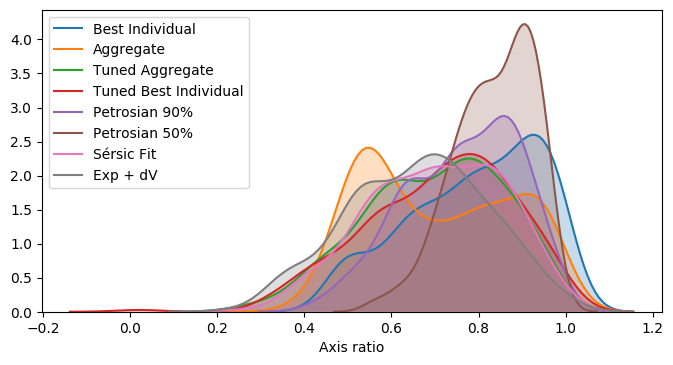

In [12]:
plt.figure(figsize=(8, 4), dpi=100)
for col in axratio_df.drop('error', axis=1).columns:
    sns.kdeplot(axratio_df[col], shade=True)
plt.xlabel('Axis ratio')

We see a distinct peak of Galaxy Builder axis ratios of 0.5, which is the default for the Zooniverse ellipse drawing tool. We need a way of dealing with this.

What is the distribution of our reported errors?

Shapiro-Wilk probability data is Normally distributed: 0.0072


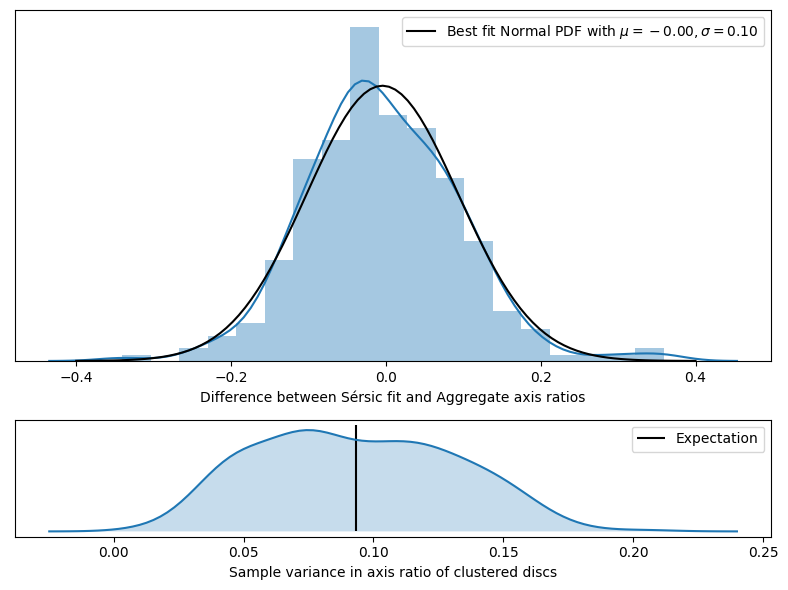

In [13]:
d = axratio_df['Sérsic Fit'] - axratio_df['Aggregate']
mu, std = st.norm.fit(d.values.T)
x = np.linspace(-0.4, 0.4, 100)
_, ax = plt.subplots(nrows=2, figsize=(8, 6), dpi=100, gridspec_kw={'height_ratios': (3, 1)})
plt.sca(ax[0])
sns.distplot(d)
plt.plot(x, st.norm.pdf(x, loc=mu, scale=std), 'k', 
         label=r'Best fit Normal PDF with $\mu={:.2f}, \sigma={:.2f}$'.format(mu, std))
plt.xlabel('Difference between Sérsic fit and Aggregate axis ratios')
plt.legend()
plt.yticks([])
plt.sca(ax[1])
sns.kdeplot(axratio_df['error'].values.T, shade=True)
plt.xlabel('Sample variance in axis ratio of clustered discs')
plt.vlines(axratio_df['error'].mean(), 0, max(plt.ylim()), label='Expectation')
plt.legend()
plt.yticks([])
plt.tight_layout()

print('Shapiro-Wilk probability data is Normally distributed: {:.4f}'.format(st.shapiro(d)[1]))

We see that compared to the NSA catalog Sérsic fit, the discrepancy is almost a normal distribution with a standard deviation around 0.1 (a normal distribution fit with varying $\mu$ and $\sigma$ is plotted), which is near the expectation value of the reported error (black line on lower panel).

## NSA catalog comparison plot

Let's compare Galaxy Builder axis ratios to that of an r-band Sersic component fit (from NSA catalog)

In [14]:
ks = ('Best Individual', 'Tuned Best Individual', 'Aggregate', 'Tuned Aggregate')

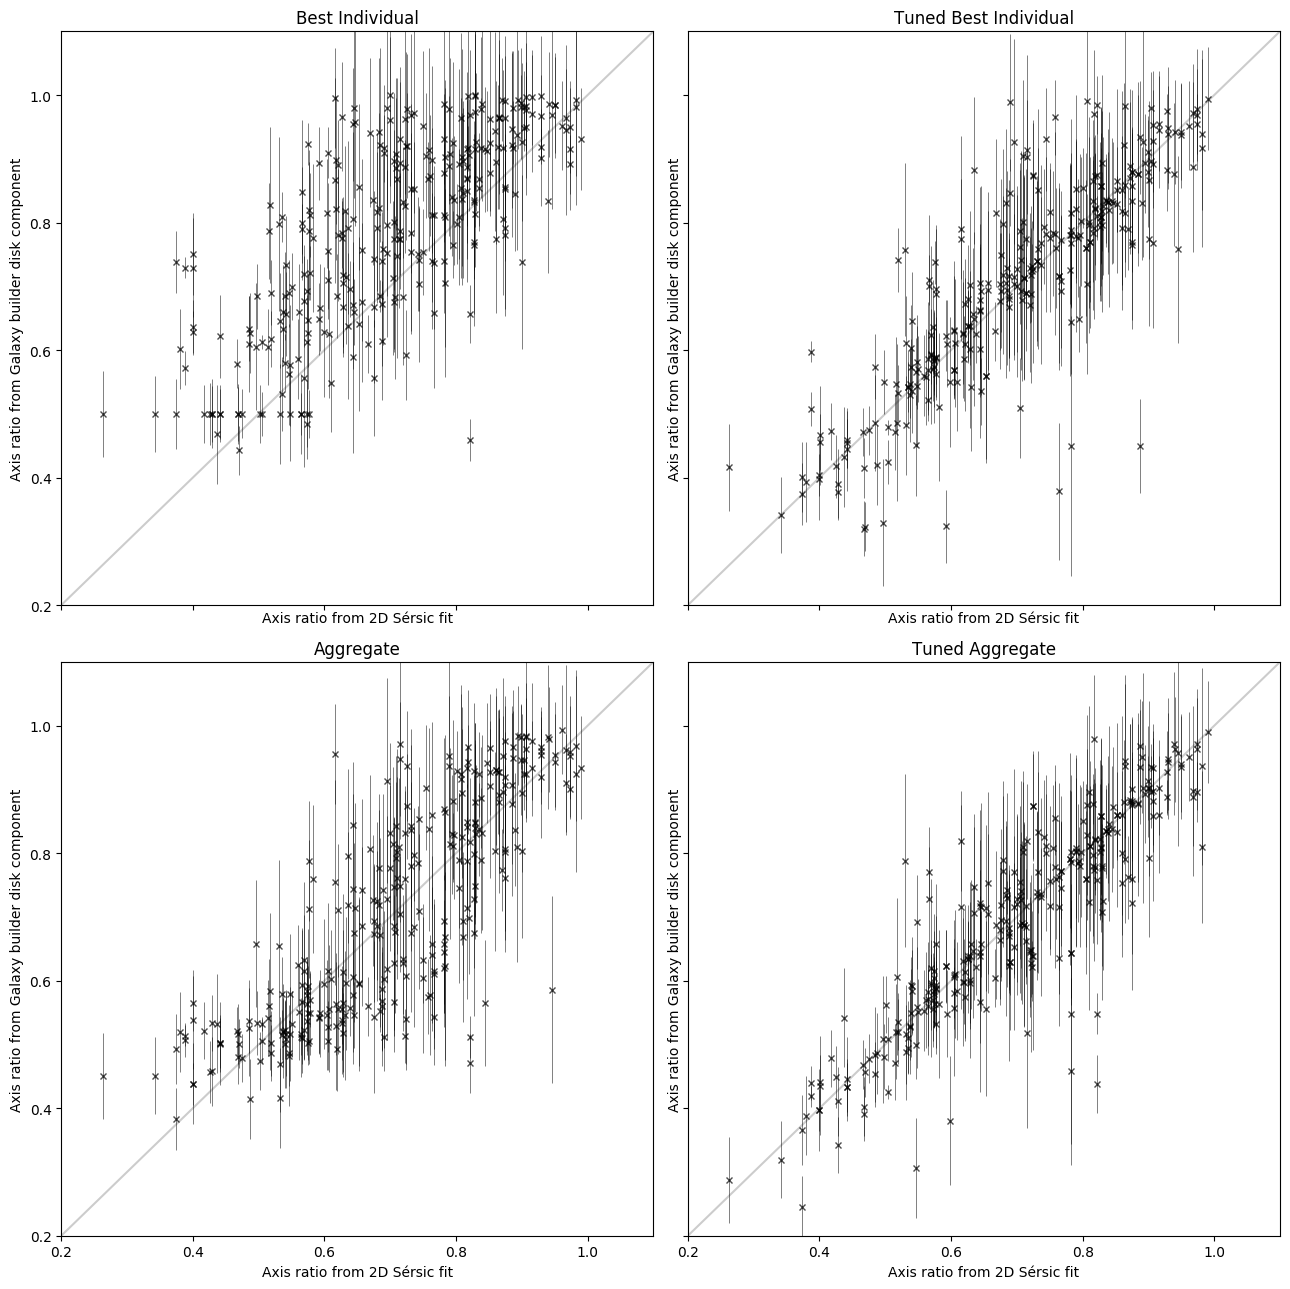

In [23]:
f, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(13, 13), dpi=100)
ax_raveled = (j for i in ax for j in i)
for a, k in zip(ax_raveled, ks):  
  a.errorbar(axratio_df['Sérsic Fit'], axratio_df[k], fmt='xk',
               yerr=axratio_df['error'],
               markersize=5, linewidth=0.5, alpha=0.7)
  a.set_xlabel('Axis ratio from 2D Sérsic fit')
  a.set_ylabel('Axis ratio from Galaxy builder disk component');
  a.set_title(k)
  a.set_xlim(0.2, 1.1)
  a.set_ylim(0.2, 1.1)
  a.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))
plt.tight_layout()
plt.savefig('method-paper-plots/gzb-agg-nsa-comparison_all.pdf', bbox_inches='tight')

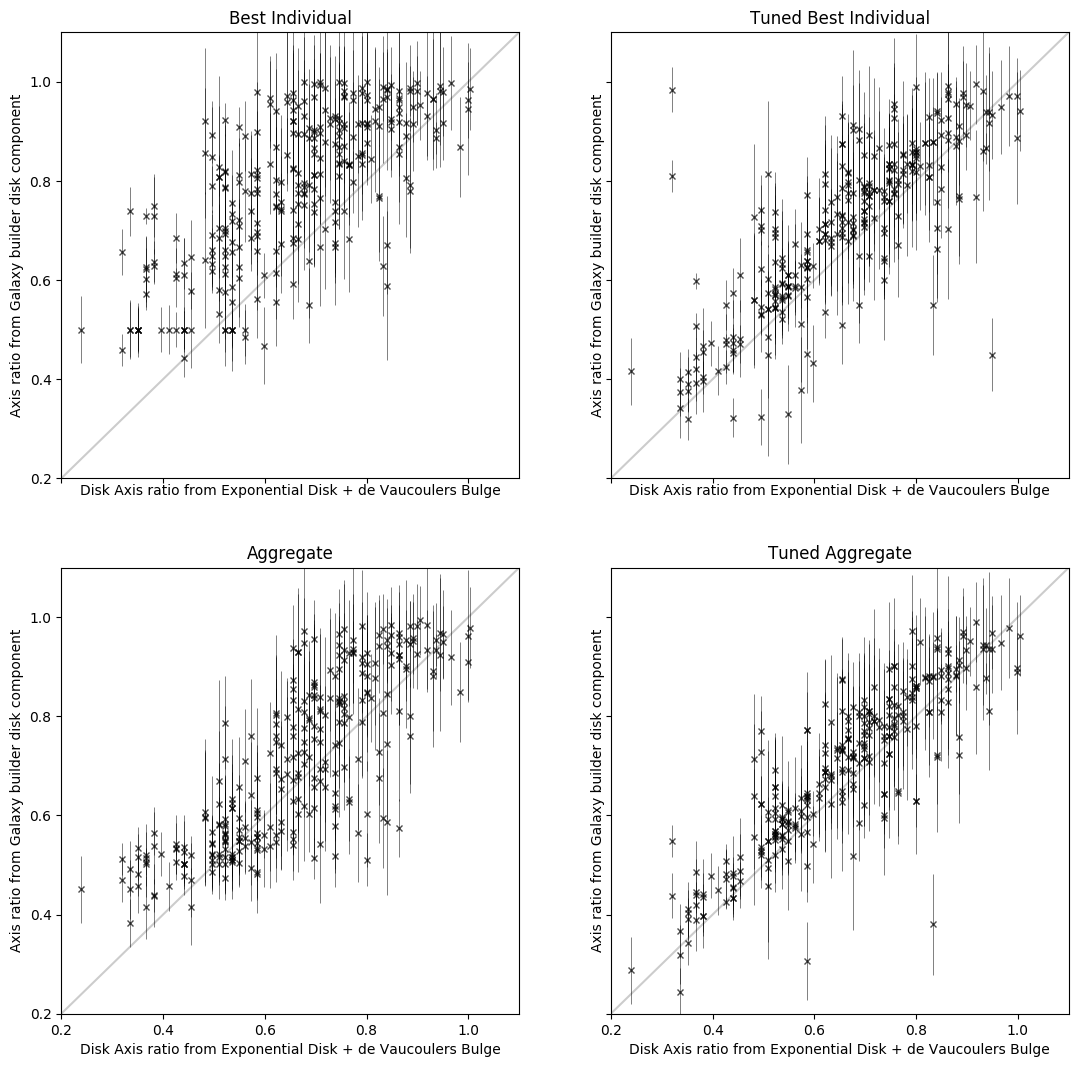

In [16]:
f, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(13, 13), dpi=100)
ax_raveled = (j for i in ax for j in i)
for a, k in zip(ax_raveled, ks):  
  a.errorbar(axratio_df['Exp + dV'], axratio_df[k], fmt='xk',
               yerr=axratio_df['error'],
               markersize=5, linewidth=0.5, alpha=0.7)
  a.set_xlabel('Disk Axis ratio from Exponential Disk + de Vaucoulers Bulge')
  a.set_ylabel('Axis ratio from Galaxy builder disk component');
  a.set_title(k)
  a.set_xlim(0.2, 1.1)
  a.set_ylim(0.2, 1.1)
  a.add_line(plt.Line2D((0, 5), (0, 5), c='k', alpha=0.2))

We'll also show this in a perhaps more informative manner: we display the discrepancies between the results and highlight points outside of $1\sigma$ and $1\sigma$ (assuming zero error on the Sérsic fit result).

In [17]:
print('Defining plot making function')
def make_outlier_plot(ytype, print_stats=True):
  diff = axratio_df['Sérsic Fit'] - axratio_df[ytype]
  # make colors
  c = np.zeros(len(diff))
  c[diff.abs() > axratio_df['error']] -= 1
  c[diff.abs() > axratio_df['error'] * 2] -= 1
  # plot
  o = np.argsort(axratio_df['Sérsic Fit'])
  c = c[o]
  plt.errorbar(diff.iloc[o], axratio_df[ytype].iloc[o],
               fmt='xk', xerr=axratio_df['error'].iloc[o],
               markersize=0, linewidth=1,
               capsize=1, alpha=0.4)
  plt.xlabel('Axis ratio from 2D Sérsic fit minus that from\nGalaxy builder disk component')
  plt.ylabel('Galaxy builder disk axis ratio')
  cs = ('k', 'C1', 'C3'); ms = (('x', 5), ('o', 4), ('*', 8))
  for i in range(3):
      plt.plot(
          diff.iloc[o][c == -i], axratio_df[ytype].iloc[o][c == -i],
          ms[i][0], color=cs[i], markersize=ms[i][1]
      )
  if print_stats:
    print('Black cross: inside 1σ ({:.2%})'.format(sum(c == 0) / len(c)))
    print('Orange dot:  between 1σ and 2σ ({:.2%})'.format(sum(c == -1) / len(c)))
    print('Red star:    outside 2σ ({:.2%})'.format(sum(c < -1) / len(c)))

print('Making gzb-agg-nsa-comparison plot')
plt.figure(figsize=(6, 6), dpi=100)
make_outlier_plot('Aggregate', print_stats=False)
plt.vlines(0, plt.ylim(), 1, alpha=0.2)
plt.tight_layout()
plt.savefig('method-paper-plots/gzb-agg-nsa-comparison.pdf', bbox_inches='tight')
plt.close()

Defining plot making function
Making gzb-agg-nsa-comparison plot


Best Individual:
Black cross: inside 1σ (50.52%)
Orange dot:  between 1σ and 2σ (27.84%)
Red star:    outside 2σ (21.65%)
Tuned Best Individual:
Black cross: inside 1σ (79.38%)
Orange dot:  between 1σ and 2σ (12.03%)
Red star:    outside 2σ (8.59%)
Aggregate:
Black cross: inside 1σ (65.64%)
Orange dot:  between 1σ and 2σ (23.37%)
Red star:    outside 2σ (11.00%)
Tuned Aggregate:
Black cross: inside 1σ (83.51%)
Orange dot:  between 1σ and 2σ (13.06%)
Red star:    outside 2σ (3.44%)


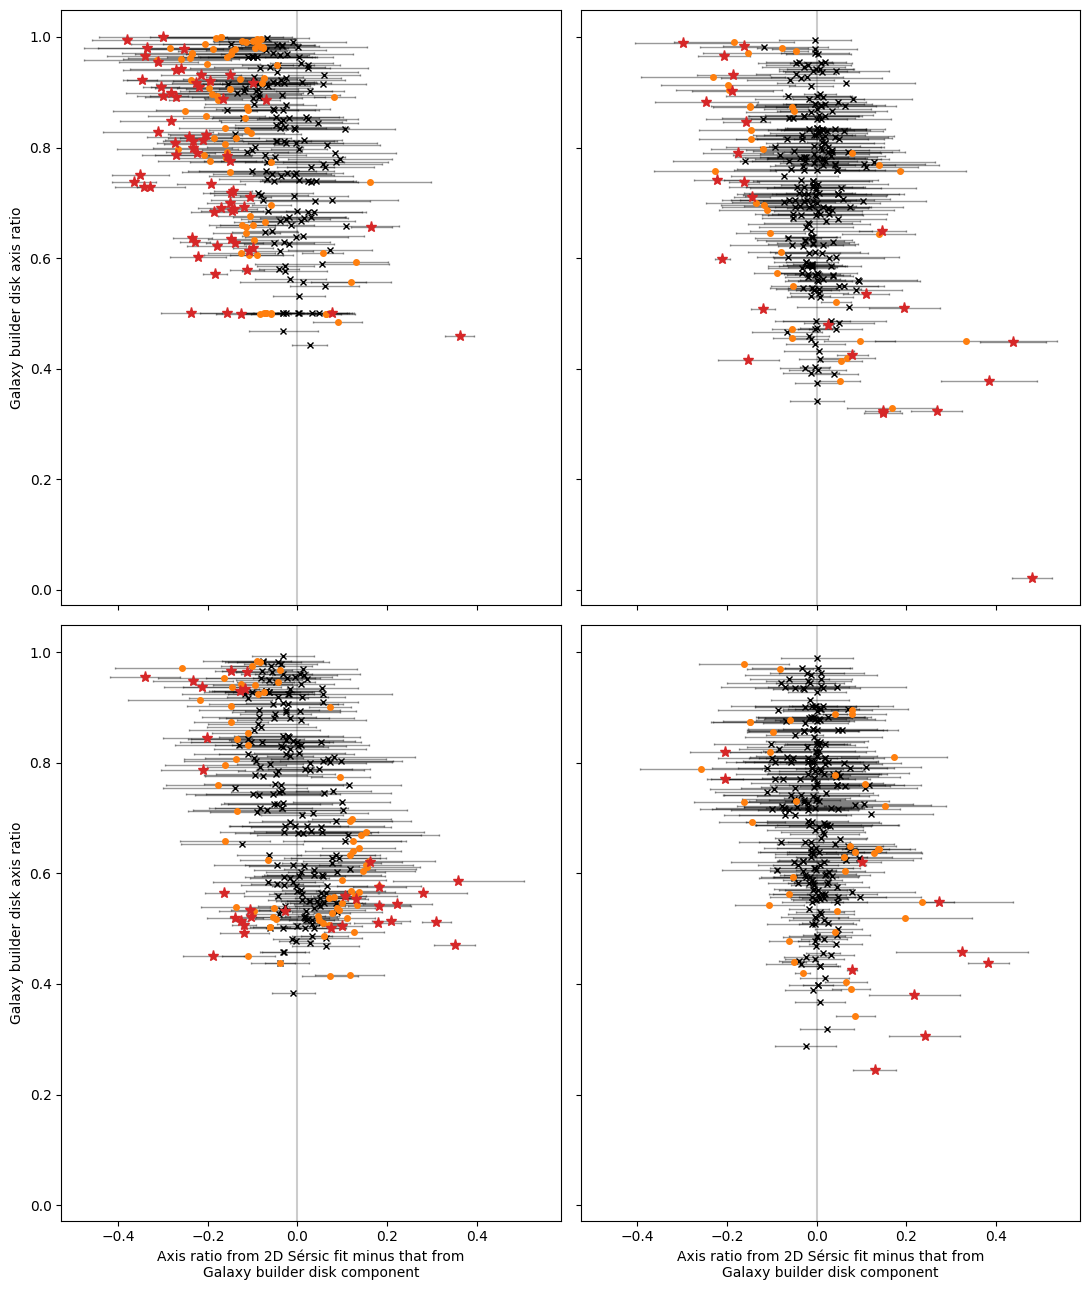

In [18]:
f, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(11, 13), dpi=100)
ax_raveled = [j for i in ax for j in i]
for a, k in zip(ax_raveled, ks): 
  plt.sca(a)
  print('{}:'.format(k))
  make_outlier_plot(k)
for a in ax_raveled:
  a.add_line(plt.Line2D((0, 0), (-10, 10), c='k', alpha=0.2))
ax[0][0].set_xlabel(None)
ax[0][1].set_xlabel(None)
ax[0][1].set_ylabel(None)
ax[1][1].set_ylabel(None)
plt.subplots_adjust(hspace=0, left=0, right=1)
plt.tight_layout()

It is obvious that the presence in a cluster of disks with the default axis ratio (very visible in the violinplot below) was causing issues with the models, which has been partly addressed by Tuning

Text(0, 0.5, 'Axis ratio')

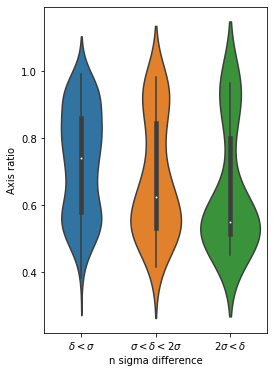

In [19]:
diff = axratio_df['Sérsic Fit'] - axratio_df['Aggregate']
# make colors
c = pd.Series(np.zeros(len(diff), dtype=int), index=axratio_df.index, name='n sigma difference')
c[diff.abs() > axratio_df['error']] += 1
c[diff.abs() > axratio_df['error'] * 2] += 1
plt.figure(figsize=(4, 6))
sns.violinplot(x='n sigma difference', y='Aggregate', data=pd.concat((axratio_df, c), axis=1))
plt.xticks([0, 1, 2], (
    r'$\delta < \sigma$',
    r'$\sigma < \delta < 2\sigma$',
    r'$2\sigma < \delta$',
))
plt.ylabel('Axis ratio')

What does a correlation matrix look like?

In [20]:
simard_comparison = pd.concat((
    axratio_df,
    simard_df['i'].apply(lambda i: np.arctan(np.deg2rad(90 - i))).rename('Simard')
), axis=1)
simard_comparison[['Sérsic Fit', 'Simard', 'Aggregate', 'Best Individual', 'Tuned Best Individual']].dropna().corr()

,Sérsic Fit,Simard,Aggregate,Best Individual,Tuned Best Individual
Sérsic Fit,1.000000,0.878370,0.817552,0.739828,0.846980
Simard,0.878370,1.000000,0.810567,0.707969,0.790042
Aggregate,0.817552,0.810567,1.000000,0.727581,0.774245
Best Individual,0.739828,0.707969,0.727581,1.000000,0.745525
Tuned Best Individual,0.846980,0.790042,0.774245,0.745525,1.000000



Comparing to NSA Sersic fit:
Aggregate = N(μ=0.0044, σ=0.0979), Shapiro-Wilk test: 0.0072
Tuned Aggregate = N(μ=-0.0037, σ=0.0713), Shapiro-Wilk test: 0.0000
Best Individual = N(μ=0.0899, σ=0.1092), Shapiro-Wilk test: 0.0057
Tuned Best Individual = N(μ=0.0071, σ=0.0890), Shapiro-Wilk test: 0.0000

Comparing to Simard catalogue:
Aggregate = N(μ=0.0467, σ=0.1008), Shapiro-Wilk test: 0.0058
Tuned Aggregate = N(μ=0.0386, σ=0.0771), Shapiro-Wilk test: 0.0000
Best Individual = N(μ=0.1321, σ=0.1180), Shapiro-Wilk test: 0.8069
Tuned Best Individual = N(μ=0.0493, σ=0.1052), Shapiro-Wilk test: 0.0000


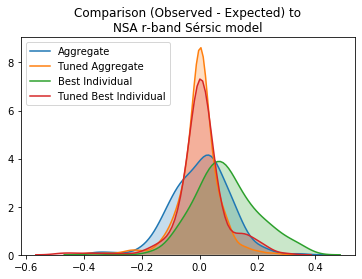

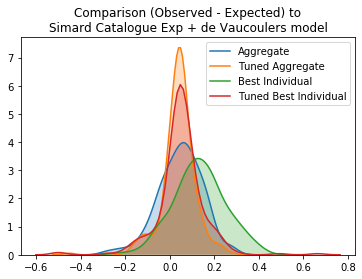

In [21]:
names = ('Aggregate', 'Tuned Aggregate', 'Best Individual', 'Tuned Best Individual')

ds_sersic = [
    simard_comparison[n] - simard_comparison['Sérsic Fit']
    for n in names
]

ds_simard = [
    simard_comparison[n] - simard_comparison['Simard']
    for n in names
]

print('\nComparing to NSA Sersic fit:')
for name, d in zip(names, ds_sersic):
    mu, sigma = st.norm.fit(d.dropna())
    sns.kdeplot(d.dropna(), shade=True, label=name)
    res = st.shapiro(d.dropna())
    print('{} = N(μ={:.4f}, σ={:.4f}), Shapiro-Wilk test: {:.4f}'.format(name, mu, sigma, res[1]))
plt.title('Comparison (Observed - Expected) to\nNSA r-band Sérsic model')
plt.legend();

plt.figure()
print('\nComparing to Simard catalogue:')
for name, d in zip(names, ds_simard):
    mu, sigma = st.norm.fit(d.dropna())
    sns.kdeplot(d.dropna(), shade=True, label=name)
    res = st.shapiro(d.dropna())
    print('{} = N(μ={:.4f}, σ={:.4f}), Shapiro-Wilk test: {:.4f}'.format(name, mu, sigma, res[1]))
plt.title('Comparison (Observed - Expected) to\nSimard Catalogue Exp + de Vaucoulers model')
plt.legend();

We see from the Shapiro-Wilk tests that the differences between our results and the existing fits are not Normally distributed (less than 1% probability that they are), so a normal fit is a bit disingenuous... HOWEVER, the kde plots (and normal fit) indicate that we are generally within our expected uncertainty of 0.1, and that's not accounting for the uncertainty in the measurements we're comparing to.

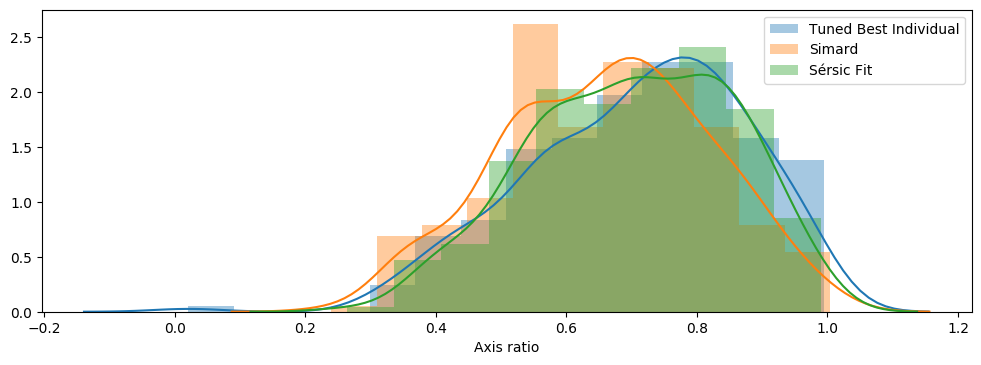

In [22]:
to_hist = ['Tuned Best Individual', 'Simard', 'Sérsic Fit']
plt.figure(figsize=(12, 4), dpi=100)
for col in to_hist:
    sns.distplot(simard_comparison.dropna()[col], label=col)
plt.xlabel('Axis ratio')
plt.legend()